In [17]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Import the raw data set into a Pandas DataFrame.

In [3]:
animals = pd.read_csv('2021-11-ml-09-k-means-animals-dataset.csv')
animals.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN,Not enough blood for isotopes.
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454,NaN
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302,NaN
3,Anvers,"Adult, 1 Egg Stage",N2A2,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426,NaN


Follow the steps in the lesson to prepare the data set for K-means clustering.

In [4]:
#checking the data types
animals.dtypes

#everything looks good

Region                  object
Stage                   object
Individual ID           object
Culmen Length (mm)     float64
Culmen Depth (mm)      float64
Flipper Length (mm)    float64
Body Mass (g)          float64
Delta 15 N (o/oo)      float64
Delta 13 C (o/oo)      float64
Comments                object
dtype: object

array([[<AxesSubplot:title={'center':'Culmen Length (mm)'}>,
        <AxesSubplot:title={'center':'Culmen Depth (mm)'}>],
       [<AxesSubplot:title={'center':'Flipper Length (mm)'}>,
        <AxesSubplot:title={'center':'Body Mass (g)'}>],
       [<AxesSubplot:title={'center':'Delta 15 N (o/oo)'}>,
        <AxesSubplot:title={'center':'Delta 13 C (o/oo)'}>]], dtype=object)

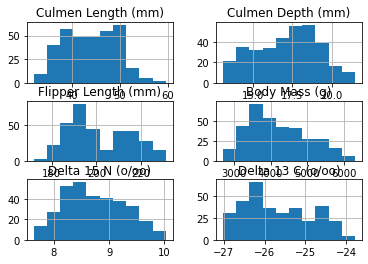

In [5]:
animals.hist()

In [6]:
animals.info()

#don't necessarily need to drop any columns (except for comments)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               344 non-null    object 
 1   Stage                344 non-null    object 
 2   Individual ID        344 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    330 non-null    float64
 8   Delta 13 C (o/oo)    331 non-null    float64
 9   Comments             26 non-null     object 
dtypes: float64(6), object(4)
memory usage: 27.0+ KB


In [7]:
animals = animals.drop(columns = 'Comments')
animals.head()

,Region,Stage,Individual ID,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Anvers,"Adult, 1 Egg Stage",N1A1,39.1,18.7,181.0,3750.0,NaN,NaN
1,Anvers,"Adult, 1 Egg Stage",N1A2,39.5,17.4,186.0,3800.0,8.94956,-24.69454
2,Anvers,"Adult, 1 Egg Stage",N2A1,40.3,18.0,195.0,3250.0,8.36821,-25.33302
3,Anvers,"Adult, 1 Egg Stage",N2A2,NaN,NaN,NaN,NaN,NaN,NaN
4,Anvers,"Adult, 1 Egg Stage",N3A1,36.7,19.3,193.0,3450.0,8.76651,-25.32426


In [8]:
#checking for null rows

print(f'oringinal length: {len(animals)}')
num_cols = len(animals.columns)
drop = []
for i in range(len(animals)):
    #print(column, animals[column].isna().sum(),len(animals)/2)
    num_null  = animals.iloc[i].isna().sum()

    #print(num_null)
    if num_null >= num_cols/2:
        print(f'index: {i}, number of null values:{num_null}')
        drop.append(i)

animals = animals.drop(index = drop)

print(f'new length: {len(animals)}')

oringinal length: 344
index: 3, number of null values:6
index: 339, number of null values:6
new length: 342


In [9]:
#imputing values


imp_mean = SimpleImputer(missing_values= np.nan, strategy='mean')
cols=['Culmen Length (mm)','Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)','Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
for col in cols:
    animals[col]=imp_mean.fit_transform(animals[[col]])

animals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Region               342 non-null    object 
 1   Stage                342 non-null    object 
 2   Individual ID        342 non-null    object 
 3   Culmen Length (mm)   342 non-null    float64
 4   Culmen Depth (mm)    342 non-null    float64
 5   Flipper Length (mm)  342 non-null    float64
 6   Body Mass (g)        342 non-null    float64
 7   Delta 15 N (o/oo)    342 non-null    float64
 8   Delta 13 C (o/oo)    342 non-null    float64
dtypes: float64(6), object(3)
memory usage: 26.7+ KB


In [10]:
# fixing extremes
def get_outliers(column):
    three_sd = 3*(animals[column].std())
    mean = animals[column].sum()/len(animals)
    max = mean + three_sd
    min = mean - three_sd
    vals = []
    for i in range(len(animals)):
        val = animals[column].iloc[i]
        if val > max:
            vals.append(val)
            #animals.at[i,column] = max
        elif val < min:
            vals.append(val)
            #animals.at[i,column] = min
    print(column, vals)

for column in animals.describe().columns:
    get_outliers(column)

Culmen Length (mm) []
Culmen Depth (mm) []
Flipper Length (mm) []
Body Mass (g) []
Delta 15 N (o/oo) []
Delta 13 C (o/oo) []


In [11]:
animals = pd.get_dummies(animals, prefix='', prefix_sep='', columns = ['Individual ID'])#drop_first=True)

In [12]:
animals.head()

,Region,Stage,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),N100A1,N100A2,...,N95A1,N95A2,N96A1,N96A2,N98A1,N98A2,N99A1,N99A2,N9A1,N9A2
0,Anvers,"Adult, 1 Egg Stage",39.1,18.7,181.0,3750.0,8.733382,-25.686292,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anvers,"Adult, 1 Egg Stage",39.5,17.4,186.0,3800.0,8.949560,-24.694540,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anvers,"Adult, 1 Egg Stage",40.3,18.0,195.0,3250.0,8.368210,-25.333020,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anvers,"Adult, 1 Egg Stage",36.7,19.3,193.0,3450.0,8.766510,-25.324260,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Anvers,"Adult, 1 Egg Stage",39.3,20.6,190.0,3650.0,8.664960,-25.298050,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:

animals = animals.drop(columns=['Region','Stage'])
animals.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),N100A1,N100A2,N10A1,N10A2,...,N95A1,N95A2,N96A1,N96A2,N98A1,N98A2,N99A1,N99A2,N9A1,N9A2
0,39.1,18.7,181.0,3750.0,8.733382,-25.686292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,39.5,17.4,186.0,3800.0,8.949560,-24.694540,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40.3,18.0,195.0,3250.0,8.368210,-25.333020,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,36.7,19.3,193.0,3450.0,8.766510,-25.324260,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,39.3,20.6,190.0,3650.0,8.664960,-25.298050,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create a model for each value of K from 2 through 5, inclusive. Create a scatterplot for each model, using color to distinguish between clusters. Create additional models for K=6 through K=9, inclusive. Then generate a scree plot for all 8 models you've created. (Hint: use the .inertia_ attribute of your K-means instance as your vertical axis values.) Judging from the scree plot, what appears to be a reasonable choice of K for this data set?

c:\Users\Shannon Bayless\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


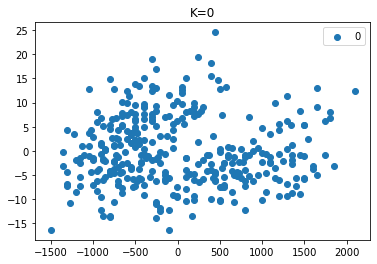

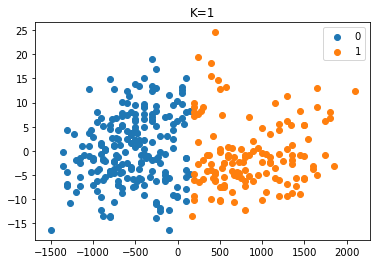

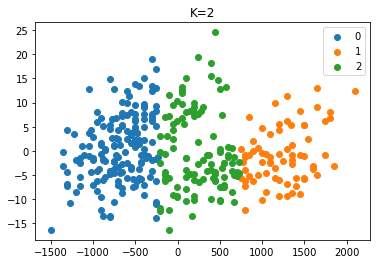

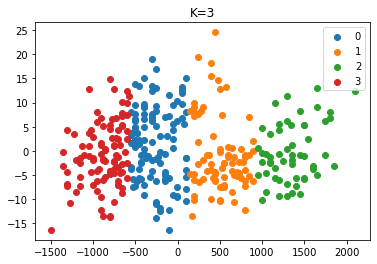

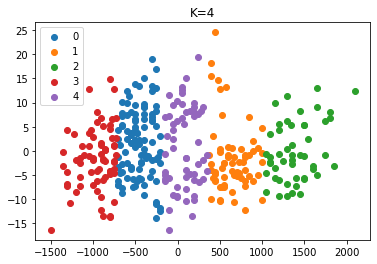

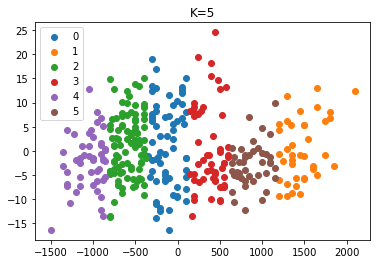

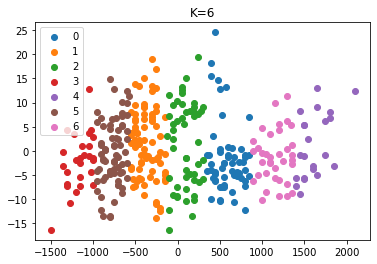

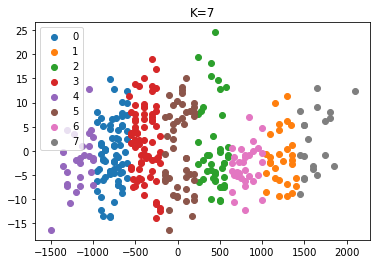

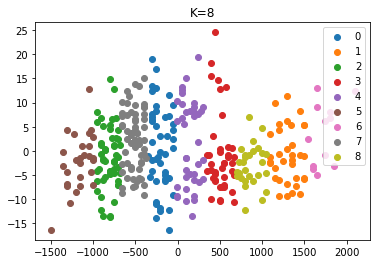

<function matplotlib.pyplot.show(close=None, block=None)>

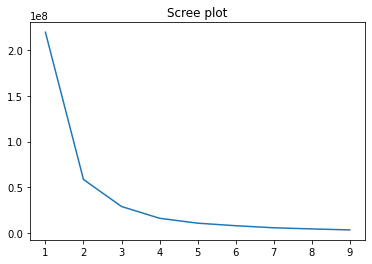

In [24]:
pca = PCA(2)
animals = pca.fit_transform(animals)

distortions = []
for  i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    label = kmeans.fit_predict(animals)
    u_labels = np.unique(label)
    distortions.append(kmeans.inertia_)
    for i in u_labels:
        plt.scatter(animals[label == i,0], animals[label == i, 1], label = i)
    plt.title(f'K={i}')
    plt.legend()
    plt.show()

plt.plot(range(1,10),distortions)
plt.title('Scree plot')
plt.show

It seems like K=2 or K=3 would be viable options for this model